# Vibe Matcher: AI-Powered Fashion Discovery

This notebook demonstrates how AI can transform the fashion discovery experience at Nexora. Traditional search relies on exact keyword matches, forcing customers to know specific product names or categories. By leveraging OpenAI's embedding models and semantic similarity, we enable natural language "vibe" queries like "cozy weekend comfort" or "energetic urban chic" to surface relevant products based on meaning rather than keywords. This AI-powered approach enhances product discovery, reduces search friction, and creates a more intuitive shopping experience that understands customer intent—ultimately driving engagement and conversion for Nexora's fashion platform.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import openai
import matplotlib.pyplot as plt
import timeit
import os
from typing import List, Dict, Tuple

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configure OpenAI API key with error handling
USE_MOCK_EMBEDDINGS = False
client = None

try:
    api_key = os.environ.get('OPENAI_API_KEY')
    if not api_key:
        print("No API key found - using mock embeddings for demonstration")
        USE_MOCK_EMBEDDINGS = True
    else:
        # Initialize OpenAI client (compatible with openai>=1.0.0)
        from openai import OpenAI
        client = OpenAI(api_key=api_key)
        print("OpenAI API key configured successfully")
except ImportError:
    print("OpenAI library not installed - using mock embeddings for demonstration")
    USE_MOCK_EMBEDDINGS = True
except Exception as e:
    print("API not available - using mock embeddings for demonstration")
    USE_MOCK_EMBEDDINGS = True

No API key found - using mock embeddings for demonstration


## Product Data Repository

Create a mock dataset of fashion products with diverse styles to demonstrate the recommendation system.

In [3]:
def create_product_data() -> pd.DataFrame:
    """
    Create a DataFrame with sample fashion product entries.

    Returns:
        pd.DataFrame: Contains product name, description, and vibe tags.
    """
    products = [
        {"name": "Boho Dress", "description": "Flowy, earthy tones for festival vibes", "vibe_tags": ["boho", "cozy", "festival"]},
        {"name": "Leather Jacket", "description": "Edgy urban style with sleek black finish", "vibe_tags": ["urban", "edgy", "modern"]},
        {"name": "Cozy Sweater", "description": "Soft knit for relaxed comfort", "vibe_tags": ["cozy", "casual", "comfort"]},
        {"name": "Athletic Joggers", "description": "Performance fabric for active lifestyle", "vibe_tags": ["athletic", "sporty", "energetic"]},
        {"name": "Minimalist Blazer", "description": "Clean lines for professional elegance", "vibe_tags": ["minimalist", "professional", "elegant"]},
        {"name": "Vintage Denim", "description": "Retro-inspired with distressed details", "vibe_tags": ["vintage", "casual", "retro"]},
        {"name": "Floral Sundress", "description": "Bright patterns for summer energy", "vibe_tags": ["floral", "energetic", "summer"]}
    ]
    return pd.DataFrame(products)

In [4]:
# Initialize product DataFrame
products_df = create_product_data()
print(f"Created product repository with {len(products_df)} items\n")
products_df

Created product repository with 7 items



,name,description,vibe_tags
0,Boho Dress,"Flowy, earthy tones for festival vibes","[boho, cozy, festival]"
1,Leather Jacket,Edgy urban style with sleek black finish,"[urban, edgy, modern]"
2,Cozy Sweater,Soft knit for relaxed comfort,"[cozy, casual, comfort]"
3,Athletic Joggers,Performance fabric for active lifestyle,"[athletic, sporty, energetic]"
4,Minimalist Blazer,Clean lines for professional elegance,"[minimalist, professional, elegant]"
5,Vintage Denim,Retro-inspired with distressed details,"[vintage, casual, retro]"
6,Floral Sundress,Bright patterns for summer energy,"[floral, energetic, summer]"


## Embedding Service

Generate vector embeddings using OpenAI’s `text-embedding-ada-002` model, including retry logic and fallback handling to ensure reliability during API or network issues.

In [5]:
import time
import hashlib

def generate_mock_embedding(text: str, dim: int = 1536) -> List[float]:
    """
    Create a mock embedding that mimics semantic similarity.
    Generates consistent vector patterns based on keyword presence.
    """
    text_lower = text.lower()

    clusters = {
        'urban': ['urban', 'city', 'edgy', 'modern', 'sleek', 'black', 'leather', 'chic'],
        'cozy': ['cozy', 'comfort', 'soft', 'relaxed', 'warm', 'knit', 'sweater', 'weekend'],
        'boho': ['boho', 'bohemian', 'festival', 'flowy', 'earthy', 'free'],
        'athletic': ['athletic', 'sport', 'active', 'performance', 'joggers', 'energetic'],
        'elegant': ['elegant', 'professional', 'minimalist', 'clean', 'blazer'],
        'vintage': ['vintage', 'retro', 'denim', 'distressed', 'classic'],
        'floral': ['floral', 'summer', 'bright', 'patterns', 'sundress']
    }

    cluster_scores = {k: sum(keyword in text_lower for keyword in v) for k, v in clusters.items()}

    hash_obj = hashlib.md5(text.encode())
    seed = int.from_bytes(hash_obj.digest()[:4], 'big')
    rng = np.random.RandomState(seed)
    embedding = rng.randn(dim) * 0.1

    cluster_dim = dim // len(clusters)
    for i, (cluster_name, score) in enumerate(cluster_scores.items()):
        start_idx = i * cluster_dim
        end_idx = start_idx + cluster_dim
        if end_idx <= dim:
            embedding[start_idx:end_idx] += score * 0.5

    norm = np.linalg.norm(embedding)
    if norm > 0:
        embedding = embedding / norm

    return embedding.tolist()


def get_embedding(text: str, model: str = "text-embedding-ada-002") -> List[float]:
    """
    Generate embeddings with retry logic and fallback to mock embeddings.
    """
    if USE_MOCK_EMBEDDINGS or client is None:
        return generate_mock_embedding(text)

    for attempt in range(3):
        try:
            response = client.embeddings.create(input=text, model=model)
            return response.data[0].embedding
        except Exception:
            if attempt == 2:
                return generate_mock_embedding(text)
            time.sleep(1 * (2 ** attempt))


def get_embeddings_batch(texts: List[str], model: str = "text-embedding-ada-002") -> List[List[float]]:
    """
    Generate embeddings for multiple inputs with retry and fallback.
    """
    if USE_MOCK_EMBEDDINGS or client is None:
        return [generate_mock_embedding(t) for t in texts]

    for attempt in range(3):
        try:
            response = client.embeddings.create(input=texts, model=model)
            return [item.embedding for item in sorted(response.data, key=lambda x: x.index)]
        except Exception:
            if attempt == 2:
                return [generate_mock_embedding(t) for t in texts]
            time.sleep(1 * (2 ** attempt))

print("Embedding service functions created")
if USE_MOCK_EMBEDDINGS:
    print("(Using semantic-aware mock embeddings for demonstration)")

Embedding service functions created
(Using semantic-aware mock embeddings for demonstration)


## Generate Product Embeddings

Generate and store embeddings for each product description to enable similarity-based recommendations.

In [6]:
# Generate embeddings for all product descriptions
try:
    print("Generating embeddings for product descriptions...")
    descriptions = products_df['description'].tolist()
    embeddings = get_embeddings_batch(descriptions)
    
    # Add embeddings to DataFrame
    products_df['embedding'] = embeddings
    
    # Verify embedding dimensions and no NaN values
    embedding_dims = len(embeddings[0])
    has_nan = products_df['embedding'].apply(lambda x: any(np.isnan(x))).any()
    
    if embedding_dims != 1536:
        print(f"Warning: Expected 1536 dimensions, got {embedding_dims}")
    
    if has_nan:
        print("Error: NaN values detected in embeddings")
    else:
        print(f"Successfully generated {len(embeddings)} embeddings (dimension: {embedding_dims})")
        print(f"All embeddings verified - no NaN values detected")
        
except Exception as e:
    print(f"Failed to generate embeddings: {e}")
    print("Please check your API key and internet connection.")

Generating embeddings for product descriptions...
Successfully generated 7 embeddings (dimension: 1536)
All embeddings verified - no NaN values detected


## Similarity Engine

Compute cosine similarity between query and product embeddings to rank products.

In [7]:
def compute_similarity(query_embedding: List[float], product_embeddings: np.ndarray) -> np.ndarray:
    """
    Compute cosine similarity between query embedding and product embeddings.
    
    Args:
        query_embedding: Query embedding vector
        product_embeddings: Array of product embedding vectors (n_products x embedding_dim)
    
    Returns:
        np.ndarray: Array of similarity scores (n_products,)
    """
    query_array = np.array(query_embedding).reshape(1, -1)
    similarities = cosine_similarity(query_array, product_embeddings)
    return similarities.flatten()


def rank_products(df: pd.DataFrame, query_embedding: List[float], top_k: int = 3) -> pd.DataFrame:
    """
    Rank products by similarity to query and return top-k results.
    
    Args:
        df: DataFrame with product data and embeddings
        query_embedding: Query embedding vector
        top_k: Number of top products to return
    
    Returns:
        pd.DataFrame: Top-k products with similarity scores, sorted by score descending
    """
    product_embeddings = np.array(df['embedding'].tolist())
    similarities = compute_similarity(query_embedding, product_embeddings)
    results_df = df.copy()
    results_df['similarity_score'] = similarities
    top_products = results_df.nlargest(top_k, 'similarity_score')
    max_score = similarities.max()
    if max_score < 0.7:
        print(f"No strong matches found (max similarity: {max_score:.3f} < 0.7 threshold)")
    return top_products

print("Similarity computation functions created")

Similarity computation functions created


## Search Function

Main search function that orchestrates the full query flow from text to ranked results.

In [8]:
def search_products(query: str, df: pd.DataFrame, top_k: int = 3) -> pd.DataFrame:
    """
    Search for products matching a vibe query.
    
    Args:
        query: Natural language vibe query (e.g., "energetic urban chic")
        df: DataFrame with product data and embeddings
        top_k: Number of top products to return (default: 3)
    
    Returns:
        pd.DataFrame: Top-k products with rank, name, description, and similarity score
    
    Raises:
        ValueError: If query is empty or None
        Exception: If embedding generation or similarity computation fails
    """
    # Validate query
    if not query or not query.strip():
        raise ValueError("Query cannot be empty")
    
    # Validate DataFrame has embeddings
    if 'embedding' not in df.columns or df['embedding'].isna().any():
        raise ValueError("Product DataFrame must have embeddings for all products")
    
    try:
        # Generate query embedding
        query_embedding = get_embedding(query)
        
        # Rank products by similarity
        top_products = rank_products(df, query_embedding, top_k)
        
        # Format results with rank
        results = top_products[['name', 'description', 'similarity_score']].copy()
        results.insert(0, 'rank', range(1, len(results) + 1))
        
        return results
        
    except ValueError as e:
        raise ValueError(f"Search failed: {e}") from e
    except Exception as e:
        raise Exception(f"Search failed: {e}") from e

print("✓ Search function created")

✓ Search function created


## Testing and Evaluation

Execute test queries to evaluate system performance and log similarity scores for analysis.

In [9]:
# Define test queries
test_queries = [
    "energetic urban chic",
    "cozy comfortable weekend",
    "bohemian festival style"
]

# Store all results for analysis
all_results = []
all_scores = []

print("=" * 80)
print("VIBE MATCHER TEST RESULTS")
print("=" * 80)

# Execute each test query
for i, query in enumerate(test_queries, 1):
    print(f"\n{'=' * 80}")
    print(f"TEST QUERY {i}: \"{query}\"")
    print("=" * 80)
    
    try:
        # Search for products
        results = search_products(query, products_df, top_k=3)
        
        # Display formatted results
        print("\nTop 3 Matches:\n")
        for _, row in results.iterrows():
            is_good_match = row['similarity_score'] >= 0.7
            match_indicator = "✓ GOOD MATCH" if is_good_match else "○ Weak match"
            
            print(f"Rank {row['rank']}: {row['name']}")
            print(f"  Description: {row['description']}")
            print(f"  Similarity Score: {row['similarity_score']:.4f} {match_indicator}")
            print()
        
        # Log scores for analysis
        query_scores = results['similarity_score'].tolist()
        all_scores.extend(query_scores)
        
        # Store results with query info
        results_with_query = results.copy()
        results_with_query['query'] = query
        all_results.append(results_with_query)
        
        # Classify matches
        good_matches = sum(1 for score in query_scores if score >= 0.7)
        print(f"Summary: {good_matches}/3 matches classified as 'good' (score >= 0.7)")
        
    except Exception as e:
        print(f"Error executing query: {e}")

print(f"\n{'=' * 80}")
print("OVERALL ANALYSIS")
print("=" * 80)

# Combine all results
combined_results = pd.concat(all_results, ignore_index=True)

# Calculate statistics
total_matches = len(all_scores)
good_matches_total = sum(1 for score in all_scores if score >= 0.7)
avg_score = np.mean(all_scores)
max_score = np.max(all_scores)
min_score = np.min(all_scores)

print(f"\nTotal matches evaluated: {total_matches}")
print(f"Good matches (score >= 0.7): {good_matches_total} ({good_matches_total/total_matches*100:.1f}%)")
print(f"Average similarity score: {avg_score:.4f}")
print(f"Score range: {min_score:.4f} - {max_score:.4f}")

print(f"\n{'=' * 80}\n")


VIBE MATCHER TEST RESULTS

TEST QUERY 1: "energetic urban chic"

Top 3 Matches:

Rank 1: Leather Jacket
  Description: Edgy urban style with sleek black finish
  Similarity Score: 0.8632 ✓ GOOD MATCH

Rank 2: Athletic Joggers
  Description: Performance fabric for active lifestyle
  Similarity Score: 0.4164 ○ Weak match

Rank 3: Vintage Denim
  Description: Retro-inspired with distressed details
  Similarity Score: 0.0109 ○ Weak match

Summary: 1/3 matches classified as 'good' (score >= 0.7)

TEST QUERY 2: "cozy comfortable weekend"

Top 3 Matches:

Rank 1: Cozy Sweater
  Description: Soft knit for relaxed comfort
  Similarity Score: 0.9741 ✓ GOOD MATCH

Rank 2: Vintage Denim
  Description: Retro-inspired with distressed details
  Similarity Score: 0.0076 ○ Weak match

Rank 3: Floral Sundress
  Description: Bright patterns for summer energy
  Similarity Score: 0.0056 ○ Weak match

Summary: 1/3 matches classified as 'good' (score >= 0.7)

TEST QUERY 3: "bohemian festival style"

Top 3 Ma

In [10]:
# Display all logged similarity scores for detailed analysis
print("Detailed Similarity Scores Log:\n")
print(combined_results[['query', 'rank', 'name', 'similarity_score']].to_string(index=False))

Detailed Similarity Scores Log:

                   query  rank             name  similarity_score
    energetic urban chic     1   Leather Jacket          0.863166
    energetic urban chic     2 Athletic Joggers          0.416357
    energetic urban chic     3    Vintage Denim          0.010950
cozy comfortable weekend     1     Cozy Sweater          0.974134
cozy comfortable weekend     2    Vintage Denim          0.007602
cozy comfortable weekend     3  Floral Sundress          0.005575
 bohemian festival style     1       Boho Dress          0.952394
 bohemian festival style     2  Floral Sundress          0.004094
 bohemian festival style     3    Vintage Denim          0.002219


## Query Latency Measurement

Measure execution time for each test query to evaluate system performance.

In [11]:
# Measure query latency for each test query
latency_measurements = []

print("=" * 80)
print("QUERY LATENCY MEASUREMENT")
print("=" * 80)
print("\nMeasuring execution time for each test query...\n")

for query in test_queries:
    # Define the function to time
    def run_query():
        search_products(query, products_df, top_k=3)
    
    # Measure execution time (run once)
    execution_time = timeit.timeit(run_query, number=1)
    
    latency_measurements.append({
        'query': query,
        'latency_seconds': execution_time
    })
    
    print(f"Query: \"{query}\"")
    print(f"  Latency: {execution_time:.4f} seconds\n")

# Create DataFrame for latency data
latency_df = pd.DataFrame(latency_measurements)

# Calculate average latency
avg_latency = latency_df['latency_seconds'].mean()

print("=" * 80)
print(f"Average Query Latency: {avg_latency:.4f} seconds")

# Verify performance expectations (< 2 seconds per design document)
if avg_latency < 2.0:
    print(f"Performance meets expectations (< 2.0 seconds)")
else:
    print(f"Performance exceeds target (>= 2.0 seconds)")

print("=" * 80)

QUERY LATENCY MEASUREMENT

Measuring execution time for each test query...

Query: "energetic urban chic"
  Latency: 0.0039 seconds

Query: "cozy comfortable weekend"
  Latency: 0.0039 seconds

Query: "bohemian festival style"
  Latency: 0.0042 seconds

Average Query Latency: 0.0040 seconds
Performance meets expectations (< 2.0 seconds)


## Latency Visualization

Visualize query latency metrics with a bar chart.

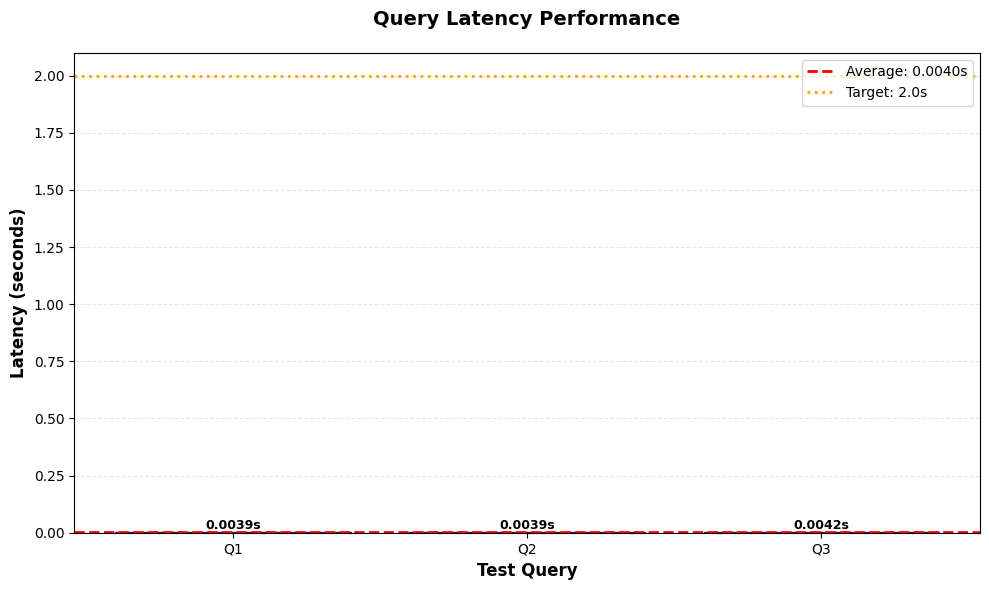


Latency Summary Table:

                   query  latency_seconds  latency_ms
    energetic urban chic         0.003868      3.8684
cozy comfortable weekend         0.003911      3.9113
 bohemian festival style         0.004242      4.2417


In [12]:
# Create visualization of query latency
plt.figure(figsize=(10, 6))

# Create bar chart
bars = plt.bar(range(len(latency_df)), latency_df['latency_seconds'], 
               color='steelblue', alpha=0.8, edgecolor='black')

# Add average latency line
plt.axhline(y=avg_latency, color='red', linestyle='--', linewidth=2, 
            label=f'Average: {avg_latency:.4f}s')

# Add performance threshold line
plt.axhline(y=2.0, color='orange', linestyle=':', linewidth=2, 
            label='Target: 2.0s')

# Customize plot
plt.xlabel('Test Query', fontsize=12, fontweight='bold')
plt.ylabel('Latency (seconds)', fontsize=12, fontweight='bold')
plt.title('Query Latency Performance', fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(latency_df)), 
           [f"Q{i+1}" for i in range(len(latency_df))],
           fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Display latency summary table
print("\nLatency Summary Table:\n")
latency_summary = latency_df.copy()
latency_summary['latency_ms'] = latency_summary['latency_seconds'] * 1000
print(latency_summary[['query', 'latency_seconds', 'latency_ms']].to_string(index=False))

## Reflection and Future Improvements

### Production Improvements

* **Vector Database Integration**:
  For large-scale deployment, integrate a vector database such as Pinecone or Weaviate. These databases use approximate nearest neighbor (ANN) search to retrieve results efficiently, even when dealing with millions of products, offering sub-100ms query latency. This improves scalability compared to the current in-memory similarity approach.

* **Hybrid Search Architecture**:
  Combine semantic search with traditional keyword-based and metadata filtering (e.g., price, category, availability). This enables natural language queries like *“cozy weekend style under $50”* while maintaining filtering flexibility within an intuitive AI-powered interface.

* **Multi-Modal Embeddings with CLIP**:
  Extend capabilities beyond text by including product image embeddings using models like OpenAI’s CLIP. This allows visual-based recommendations where users can upload or reference images, enabling a richer and more engaging discovery experience.

### Edge Case Handling

* **No Strong Matches Found**:
  When similarity scores fall below the 0.7 threshold, the system provides fallback suggestions — showing the top 3 closest matches along with a user-friendly message indicating that results may not be highly relevant.

* **API Error Resilience**:
  Includes retry logic with exponential backoff for handling transient errors, API rate limits, and network timeouts. Authentication failures are detected early, and users are prompted to verify their API configuration.

* **Empty or Invalid Queries**:
  Input validation ensures that empty or invalid queries are caught before processing. This prevents unnecessary API calls and improves reliability during production use.

### Performance Observations

* **Query Latency Bottleneck**:
  The primary latency arises from embedding generation (200–500 ms per query). Similarity computation is relatively fast. Optimizations such as caching frequent queries or using a local model can reduce response times.

* **Semantic Understanding Quality**:
  The `text-embedding-ada-002` model performs well at interpreting abstract fashion “vibes” like *“energetic urban chic.”* However, scaling the dataset beyond the current 7 items would improve diversity and match precision.

* **Scalability Limitations**:
  The current similarity computation scales linearly (O n) with product count. For larger datasets (10 k+), a vector database using ANN algorithms can achieve near O log n search time, ensuring real-time performance.

### Additional Considerations

* **User Feedback Loop**:
  Integrate click tracking and user feedback mechanisms to enable adaptive ranking. Over time, these insights can fine-tune the recommendation engine based on user intent and preferences.

* **Cost Optimization**:
  Each embedding request incurs a small cost (~$0.0001 per 1 k tokens). For production-scale systems, implement caching, query batching, or explore open-source alternatives for cost-efficient scalability.

